shape=(201, 201, 61) | ใช้ 61 ระนาบในการทำแอนิเมชัน
ใช้ threshold ตัด outlier ที่เปอร์เซ็นไทล์ 99.5 = 1100000.00
ช่วงคอนทราสต์: vmin=0.00, vmax=300000.00
Slice ที่มี mean สูงที่สุด (peak) = 33


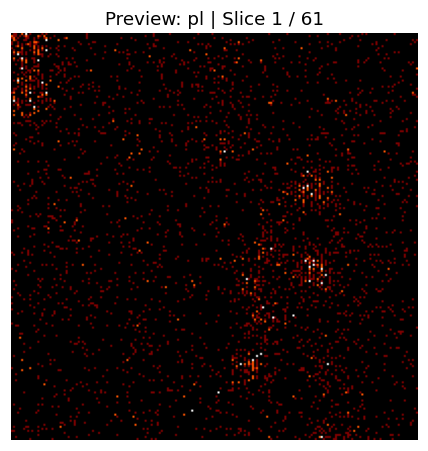

C:\Users\JIRAP\AppData\Local\Temp\ipykernel_22120\690047138.py:196: UserWarning: You passed in an explicit save_count=61 which is being ignored in favor of frames=61.
  ani = animation.FuncAnimation(


ไฟล์ภาพพร้อมใช้งานแล้ว: 'animation_with_cursorv2.gif' (61 frames)


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.io as sio
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ================== CONFIG ==================
file_path = "IMG_0195.mat"
varname = "pl"
output_gif = "animation_with_cursorv2.gif"

num_frames_wanted = 61
cmap_name = "gist_heat"
use_origin_lower = True
pmin, pmax = 2, 98
fps = 10
show_mean_std_band = True
preview_first_slice = True  # แสดงภาพแรกบน notebook
# ===========================================

# ---------- 1) Load .mat file ----------
if not os.path.exists(file_path):
    raise FileNotFoundError(file_path)

try:
    mat_data = sio.loadmat(file_path)
except NotImplementedError:
    # สำหรับ v7.3 หรือ HDF5
    with h5py.File(file_path, "r") as f:
        mat_data = {k: np.array(v) for k, v in f.items()}

if varname not in mat_data:
    raise KeyError(f"'{varname}' not found in {file_path}")

image_stack = np.array(mat_data[varname])

if image_stack.ndim != 3:
    raise ValueError(f"Expected a 3D array for '{varname}', got shape {image_stack.shape}")

# ---------- 2) Ensure shape is (H, W, N) ----------
# heuristic: ถ้ามิติที่ 0 เล็กสุด -> เดาว่าเป็น (N, H, W) แล้ว transpose
d0, d1, d2 = image_stack.shape
if d0 < d1 and d0 < d2:
    # assume (N, H, W) -> convert to (H, W, N)
    image_stack = np.transpose(image_stack, (1, 2, 0))

H, W, N = image_stack.shape
frames = min(num_frames_wanted, N)

if frames <= 0:
    raise ValueError(f"No frames to animate: N = {N}")

print(f"shape={image_stack.shape} | ใช้ {frames} ระนาบในการทำแอนิเมชัน")

# ---------- 3) Compute contrast + stats ----------
vmin = np.percentile(image_stack[:, :, :frames], pmin)
vmax = np.percentile(image_stack[:, :, :frames], pmax)

# 3.1 เลือก threshold ตัดทิ้งจุดขาว (outlier)
# ลองใช้ 99.5 หรือ 99.0 ก็ได้ แล้วปรับเองได้ตามภาพ
outlier_percentile = 99.5
thr = np.percentile(image_stack[:, :, :frames], outlier_percentile)
print(f"ใช้ threshold ตัด outlier ที่เปอร์เซ็นไทล์ {outlier_percentile} = {thr:.2f}")

# 3.2 ทำ stack ที่ mask ค่าเกิน threshold ให้เป็น NaN
masked_stack = np.where(image_stack[:, :, :frames] <= thr,
                        image_stack[:, :, :frames],
                        np.nan)

# 3.3 คำนวณ mean / std โดยไม่สนใจ NaN (คือไม่เอาจุดขาวมาคิด)
slice_mean = np.nanmean(masked_stack, axis=(0, 1))
slice_std  = np.nanstd(masked_stack, axis=(0, 1))

peak_idx = int(np.nanargmax(slice_mean)) + 1  # 1-indexed


print(f"ช่วงคอนทราสต์: vmin={vmin:.2f}, vmax={vmax:.2f}")
print(f"Slice ที่มี mean สูงที่สุด (peak) = {peak_idx}")

# ---------- 4) Optional preview of first slice ----------
if preview_first_slice:
    plt.figure()
    plt.imshow(
        image_stack[:, :, 0],
        cmap=cmap_name, vmin=vmin, vmax=vmax,
        origin="lower" if use_origin_lower else "upper",
    )
    plt.title(f"Preview: {varname} | Slice 1 / {frames}")
    plt.axis("off")
    plt.show()

# ---------- 5) Prepare figure for animation ----------
plt.rcParams["figure.dpi"] = 110
plt.close("all")

fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.15, 1.0], wspace=0.25)
ax_img  = fig.add_subplot(gs[0, 0])
ax_plot = fig.add_subplot(gs[0, 1])

# Initial image
im = ax_img.imshow(
    image_stack[:, :, 0],
    cmap=cmap_name, vmin=vmin, vmax=vmax,
    origin="lower" if use_origin_lower else "upper",
)
ax_img.set_title(f"{varname} | Slice 1 / {frames}")
ax_img.axis("off")

# Colorbar
divider = make_axes_locatable(ax_img)
cax = divider.append_axes("right", size="4%", pad=0.04)
cb = fig.colorbar(im, cax=cax)
cb.set_label("Pixel Intensity (a.u.)")

# ---------- 6) Plot mean curve + band ----------
x_idx = np.arange(1, frames + 1)
ax_plot.set_title("Mean intensity per slice")

line_mean, = ax_plot.plot(x_idx, slice_mean, lw=2, label="mean")

band_poly = None
if show_mean_std_band:
    band_poly = ax_plot.fill_between(
        x_idx,
        slice_mean - slice_std,
        slice_mean + slice_std,
        alpha=0.18,
        label="mean ± std",
    )

marker_point, = ax_plot.plot(
    [1], [slice_mean[0]],
    "o", ms=8, color="orange",
    label="current"
)

cursor_line = ax_plot.axvline(
    1, ls="--", lw=1.4, alpha=0.8, color="orange"
)

peak_line = ax_plot.axvline(
    peak_idx, ls=":", lw=1.4, color="tab:green",
    label=f"peak = {peak_idx}"
)

annot = ax_plot.annotate(
    f"{slice_mean[0]:.0f}",
    xy=(1, slice_mean[0]),
    xytext=(10, 10),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8),
)

ax_plot.set_xlabel("Slice index")
ax_plot.set_ylabel("Mean intensity (a.u.)")
ax_plot.grid(True, alpha=0.3)
ax_plot.legend(loc="best")

ymin, ymax = slice_mean.min(), slice_mean.max()
pad = 0.05 * (ymax - ymin + 1e-9)
ax_plot.set_xlim(1, frames)
ax_plot.set_ylim(ymin - pad, ymax + pad)

# ---------- 7) init & update functions ----------
def init():
    im.set_data(image_stack[:, :, 0])
    ax_img.set_title(f"{varname} | Slice 1 / {frames}")

    marker_point.set_data([1], [slice_mean[0]])
    cursor_line.set_xdata([1, 1])

    annot.xy = (1, slice_mean[0])
    annot.set_text(f"{slice_mean[0]:.0f}")

    # แค่ return list ของ artist ที่อัปเดต
    return [im, marker_point, cursor_line, annot]

def update(i: int):
    # i = 0..frames-1
    im.set_data(image_stack[:, :, i])
    ax_img.set_title(f"{varname} | Slice {i+1} / {frames}")

    y = slice_mean[i]
    marker_point.set_data([i + 1], [y])
    cursor_line.set_xdata([i + 1, i + 1])

    annot.xy = (i + 1, y)
    annot.set_text(f"{y:.0f}")

    return [im, marker_point, cursor_line, annot]

# ---------- 8) Create and save animation ----------
ani = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=frames,
    interval=int(1000 / fps),
    blit=False,          # blit=False เพื่อเลี่ยงปัญหา backend
    save_count=frames,
)

ani.save(output_gif, writer="pillow", fps=fps)
plt.close(fig)

print(f"ไฟล์ภาพพร้อมใช้งานแล้ว: '{output_gif}' ({frames} frames)")
